# Introduction to Machine Learning

The aim of this tutorial is to provide a basic introduction to solving simple Machine learning problems with `scikit-learn`.

It does not focus on the underlying theory of specific algorithms, but does introduce the basic concepts behind machine learning.

Access this notebook in a cloud environment on google colab:

http://tiny.cc/hackstir

## Introduction

### What is Machine Learning

To me... 

$ \text{Machine learning} = \text{statistics} + \text{hype} + \dfrac{\text{performance}}{\text{understanding}} $
 
 The biggest difference to statistics is that Machine learning prioritises performance over understanding...

---

_Machine Learning_ - "A computer **learning** how to be **successful** at a certain task without explicitly being programmed to do so."

**learning** : i.e. recognising patterns (requires data)

**successful** : with success defined by some metric 
    (make sure your definition of success matches!)

<!-- **task** : -->

A good model will generalise - it will perform well on unseen data

---

Two main flavours:
    
* Supervised - trying to predict a specific target
    * Regression - continuous output 
        (e.g. linear regression)
    * Classification - categorical output 
        (e.g. logistic regression)

* Unsupervised - trying to find general structure in data
    * No labels
    
We will focus mainly on supervised today but will briefly go into unsupervised learning.

---

**Small glossary:**
    
* Input data is a 2D array, `X`.
* A column of `X` is a feature
* A row of `X` is a sample
* **Estimator** - the python object that learns from data
* In supervised learning the quantity we are trying to predict is called the **Target/label** and is usually denoted as `y`.

### What is `scikit-learn`?

`scikit-learn` is a Python package that provides efficient implementations of the most common machine learning algorithms, unified by an accessible API and extensive online documentation.

Super easy to use... badly

You can ingest data, train a model, and get predictions with a few lines of code **but** you never should.

You should always:
* Read the documentation - default parameters are often sub-optimal or may be subtly wrong for your use-case
* Understand the limitations of the models implemented
* Understand general best practices and incorporate them into a principled workflow
    * We won't have enough time today to cover all of this but will focus on the most important aspects and signpost towards more concepts

### Example task

**Iris dataset**

Well known example dataset.

There are three species of Iris flower, that can be characterised by the widths and heights of their petal and sepal.

![](figures/iris_petal_sepal.png)

In [1]:
# Let's import some libraries we'll be needing today
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Load the dataset from seaborn (it's also bundled in scikit-learn)
df_raw = sns.load_dataset('iris')  
display(df_raw.head())  # Look at the first five elements
df_raw.shape

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


(150, 5)

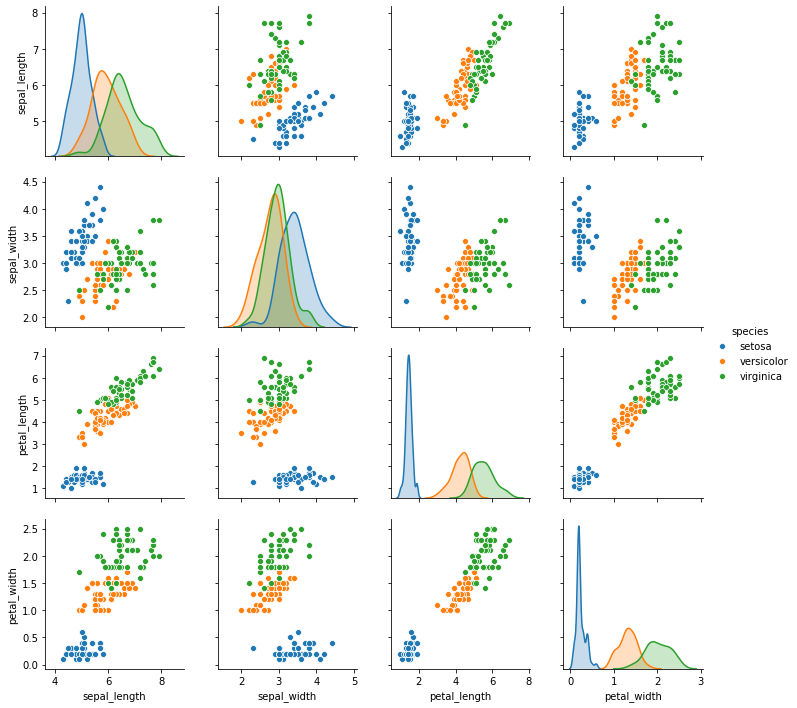

In [3]:
sns.pairplot(df_raw, hue='species')  # Analyse the distribution

In [4]:
# We create dummy (indicator) variables for each species label
df = pd.get_dummies(df_raw)
display(df.head().T)  # show first 5 rows (transposed for readability)

,0,1,2,3,4
sepal_length,5.1,4.9,4.7,4.6,5.0
sepal_width,3.5,3.0,3.2,3.1,3.6
petal_length,1.4,1.4,1.3,1.5,1.4
petal_width,0.2,0.2,0.2,0.2,0.2
species_setosa,1.0,1.0,1.0,1.0,1.0
species_versicolor,0.0,0.0,0.0,0.0,0.0
species_virginica,0.0,0.0,0.0,0.0,0.0


For now, we're just going to focus on the problem of predicting whether the species is "versicolor" or not - the not class containing both "setosa" and "virginica" flowers.

In [5]:
target = 'species_versicolor'  # the column we want to predict

## The good old-fashioned way... statistics

We use `statsmodels` to fit a plain, old Logistic Regression (Logit) on the data and spit us out a familiarly comfortable regression table.

In [6]:
from statsmodels.discrete.discrete_model import Logit

# Use patsy to specify a model formulation 
# (just like you would with R)
# https://patsy.readthedocs.io/en/latest/formulas.html
fml = f"{target} ~ sepal_length + sepal_width + petal_length + petal_width"

# Use statsmodels to fit a Logit model
logit = Logit.from_formula(fml, df)
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.483566
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     species_versicolor   No. Observations:                  150
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                            4
Date:                Tue, 22 Oct 2019   Pseudo R-squ.:                  0.2403
Time:                        08:47:31   Log-Likelihood:                -72.535
converged:                       True   LL-Null:                       -95.477
Covariance Type:            nonrobust   LLR p-value:                 2.603e-09
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.3785      2.499      2.952      0.003       2.480      12.277
sepal_length    -0.2454      0.650     -0.378      0.706      -1.518       1.028
sepal_width     -2.7966      0.784     -3.569      0.000      -4.332      -1.261
petal_length     1.3136      0.684      1.921      0.055      -0.027       2.654
petal_width     -2.7783      1.173     -2.368      0.018      -5.078      -0.479
================================================================================
"""

## A different perspective... Supervised Machine Learning

Now we will solve the same problem using `scikit-learn` from a machine learning perspective to see how the approaches differ.

### First steps

In [7]:
# Separate our features (`X`) and our labels (`y`)
X, y = df.filter(regex='sepal|petal', axis=1), df[target]

print(f"Size of `X` is: {X.shape}")
print(f"Features of `X` are: {X.columns.values}")
print(f"Size of `y` is: {y.shape}")

Size of `X` is: (150, 4)
Features of `X` are: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width']
Size of `y` is: (150,)


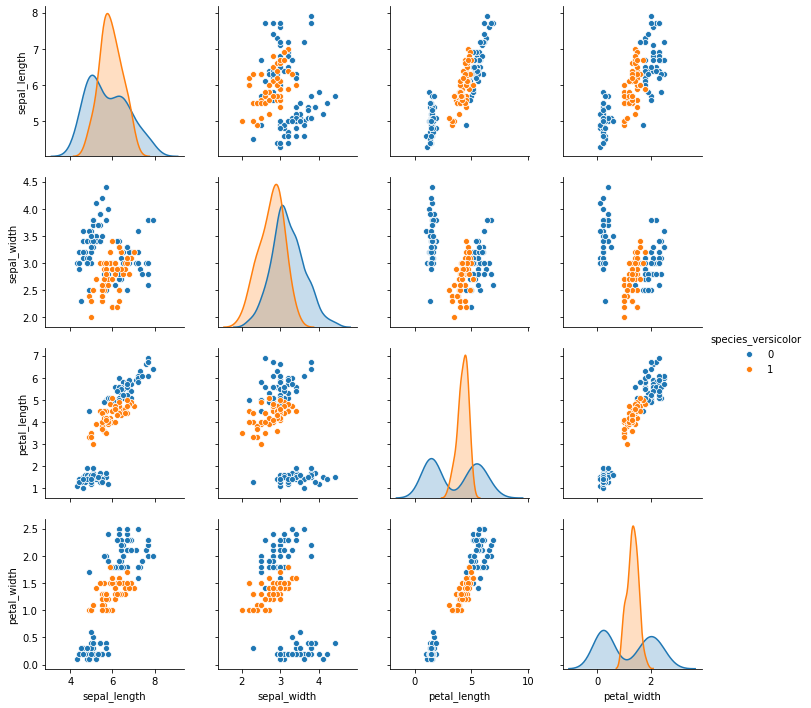

In [8]:
sns.pairplot(df, hue=target, vars=X.columns)  # A cheeky peek at the distribution

In [9]:
# Import scikit-learn's logistic regression estimator
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()  # Initialise the estimator
lr_model.fit(X, y)  # Feed it data to fit the model with

# Extract the coefficients  and assess the accuracy
(pd.DataFrame(lr_model.coef_, columns=X.columns, index=['Results'])
 .assign(intercept=lr_model.intercept_)
 .assign(accuracy=lr_model.score(X, y))
 .T
)

/home/alex/anaconda3/envs/tutorials/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Results
sepal_length,0.427509
sepal_width,-1.612116
petal_length,0.575817
petal_width,-1.406173
intercept,1.093925
accuracy,0.700000


Our model achieves 70% accuracy - not bad!

**But** our coefficients are different to those we got out of `statsmodels`.

Remember what I said earlier about it being easy to use `scikit-learn` badly?

We didn't look at the documentation, lets do that now.
We can look up the documentation in a notebook environment by typing the function/class name followed by a question mark...

In [10]:
LogisticRegression?

`LogisticRegression` performs L2 regularisation by default (`penalty='l2'`) tuned by parameter `C` (`C=1.0`).

There's no way to turn this off with the default `liblinear` solver, we can set `C` to a really large number to effectively negate the effects of the regularisation.

Alternatively we can choose another solver such as LBFGS (`solver='lbfgs'`) - which we have already been informed will become the default in the next release - and set `penalty='none'`.

Lets try that...

In [11]:
lr_model = LogisticRegression(penalty='none', solver='lbfgs')
lr_model.fit(X, y)

(pd.DataFrame(lr_model.coef_, columns=X.columns, index=['Results'])
 .assign(intercept=lr_model.intercept_)
 .assign(accuracy=lr_model.score(X, y))
 .T
)

,Results
sepal_length,-0.245357
sepal_width,-2.796563
petal_length,1.313654
petal_width,-2.778369
intercept,7.378466
accuracy,0.740000


That's fixed! 

So far there doesn't appear to be much difference beside the fact that `scikit-learn` doesn't give us a summary table and that it uses accuracy over Pseudo-$R^2$.

That's because we haven't accounted for what we said at the beginning about generalisability - "a good machine learning model will perform well on unseen data".

In order to test the generalisation of our model we need to hold some data back (**test set**) and only train on the rest (**train set**).



### Constructing a train-test split

In [12]:
# Test-train split
# EASY WAY
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.4,  # Iris is a pretty easy task so we make it a little harder
    shuffle=True,
    random_state=42,
)

A few notes:

* Always shuffle your data before splitting (order may introduce bias)
    * (Unless your data are a set of time-series - more complicated considerations/strategies are required)
* Set and store `random_state`, the seed for the random number generator such that you are working with the same split each time
* The size of your train set will depend on the size of your data - smaller data sets need all the data they can get!

In [13]:
lr_model = LogisticRegression(solver='lbfgs', penalty='none')
lr_model.fit(X_train, y_train)

(pd.DataFrame(lr_model.coef_, columns=X.columns, index=['Results'])
 .assign(intercept=lr_model.intercept_)
 .assign(train_accuracy=lr_model.score(X_train, y_train)) # Train score
 .assign(test_accuracy=lr_model.score(X_test, y_test)) # Test score
 .T
)

,Results
sepal_length,0.930530
sepal_width,-4.082729
petal_length,0.070061
petal_width,-1.371528
intercept,7.307492
train_accuracy,0.766667
test_accuracy,0.733333


But should we keep the penalty removed or should we set it?

If we remove it (cell below) we get the same test accuracy as before, but a lower train accuracy.

Now the test accuracy is higher than the train accuracy (this is just a coincidence for this train-test split) but the test and train accuracies are more similar - our model is probably **overfitting** (the model is just memorising examples) less.

<!-- We see that adding regularisation results in the train accuracy dropping - by reducing the extent to which our model overfits we increase its ability to generalise to unseen data (the test set). -->

In [14]:
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train, y_train)

(pd.DataFrame(lr_model.coef_, columns=X.columns, index=['Results'])
 .assign(intercept=lr_model.intercept_)
 .assign(train_accuracy=lr_model.score(X_train, y_train)) # Train score
 .assign(test_accuracy=lr_model.score(X_test, y_test)) # Test score
 .T
)

,Results
sepal_length,0.139796
sepal_width,-1.800765
petal_length,0.224555
petal_width,-0.654729
intercept,3.804367
train_accuracy,0.716667
test_accuracy,0.733333


A visual illustration of an overfitting model (green) vs a regularised model (black) is given below:

<img src="figures/overfitting.png" width=400>

But next we should ask ourselves how much regularisation should we add (what value of `C`)? What type of `penalty`?

We _could_ just keep evaluating many different values and looking at whether our test accuracy is increasing; however this isn't very principled. 
Knowledge about the test set "leaks" into the models as we are optimising hyper-parameters for the test set which may not generalise to some hypothetical super-secret extra test set (**validation set**).
Doing this three-way partition reduces the number of sample we can effectively learn from even more.

Instead we use something called **cross-validation** to compare acrosss models/hyper-parameters without needing to create a separate validation set.

**Cross-validation** (CV)

We create a test set as usual for the final validation, but we split the train set into $k$ smaller sets (_k_-fold CV).

We then train a model using $k-1$ folds, and evaluate the model using the remaining fold (i.e. it functions as a test set). This is then repeated for each combination of $k-1$ folds with the average of the values taken to be the models performance.

![](figures/grid_search_cross_validation.png)

In [15]:
from sklearn.model_selection import cross_val_score

# `cross_val_score` does cross validation, fitting, predicting, scoring
cv_kwargs = dict(scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
scores = cross_val_score(lr_model, X_train, y_train, **cv_kwargs)
print(f"Average cross val score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Average cross val score: 0.617 (+/- 0.064)


**Grid Search**

`GridSearchCV` provides us a convenient way to search across a parameter space.

We pass our model, a parameter grid to search over, and a scoring function and it takes care of changing hyper-parameters, cross-validation, fitting, and evaluation!

In [16]:
from sklearn.model_selection import GridSearchCV

# Define two different grids to search over
param_grid = [{'C': [0.1, 1, 10, 100],
               'penalty': ['l1', 'l2'],
               'solver': ['liblinear'],
               'max_iter': [1000],
              'intercept_scaling': [0.00010, 0.1, 0.5, 1, 5, 10]},
             {'solver': ['lbfgs'], 'penalty': ['none']}]

grid = GridSearchCV(lr_model, param_grid, **cv_kwargs)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}, with score {grid.best_score_:.3f}")

Best parameters: {'C': 10, 'intercept_scaling': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}, with score 0.717


/home/alex/anaconda3/envs/tutorials/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
# Lets look at the top 10 results
(pd.DataFrame(grid.cv_results_)
 .sort_values('mean_test_score', ascending=False)
 .filter(regex='param_|mean_test', axis=1)
 .head(10)
)
# A lot of values are very similar - our defaults are actually performing as well

,param_C,param_intercept_scaling,param_max_iter,param_penalty,param_solver,mean_test_score
48,NaN,NaN,NaN,none,lbfgs,0.716667
46,100,10,1000,l1,liblinear,0.716667
44,100,5,1000,l1,liblinear,0.716667
42,100,1,1000,l1,liblinear,0.716667
35,10,10,1000,l2,liblinear,0.716667
38,100,0.1,1000,l1,liblinear,0.700000
30,10,1,1000,l1,liblinear,0.700000
32,10,5,1000,l1,liblinear,0.700000
33,10,5,1000,l2,liblinear,0.700000
34,10,10,1000,l1,liblinear,0.700000


Sometimes we might have a fixed computational budget (i.e. number of times we can fit our model) that is less than the space we want to search. 

We can specify distributions (or iterables) for parameters and randomly search over them for some number of iterations `n_iter` using `RandomizedSearchCV`.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss

param_grid = {'C': ss.expon(scale=10),
              'intercept_scaling': ss.expon(scale=1),
                'max_iter': [1000],
               'penalty': ['l1', 'l2'],
               'solver': ['liblinear'],
              }

grid = RandomizedSearchCV(lr_model, param_grid, n_iter=10, **cv_kwargs, iid=False, random_state=13)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}, with score {grid.best_score_:.3f}")

Best parameters: {'C': 6.0412810727372666, 'intercept_scaling': 0.9391563253066986, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}, with score 0.699


## Composability

An important aspect of ML is composing several estimators or transformers together into one pipeline.

For example, we may scale and/or perform PCA on our data before passing it to the final estimator.

It is important that all these operations are also performed within cross-validation.

Luckily we can easily compose together estimators and transformers within `scikit-learn` to form a `Pipeline` object which can fit, predict and be passed to functions such as `GridSearchCV` just like a regular estimator.


In [19]:
# Sometimes when doing a large grid-search we end up with some very bad parameters

# Let's ignore these warnings so our screen isn't filled up with messages
# (do pay attention to them first time around though)
import warnings
warnings.filterwarnings("ignore", category=skl.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA


# A pipeline is a `list` of `tuple`s with the first element of the tuple being
# the name of the step, and the second element being a scikit-learn estimator/transformer.
# This list of steps is passed to `sklearn.pipeline.Pipeline`
steps = [('scaling', None),
         ('pca', PCA()),
         ('LR', LogisticRegression(solver='liblinear')),
        ]
pipeline = Pipeline(steps)

# GRID
# The labels for our grid need to be prefixed by the pipeline step we are tuning
# a hyperparameter for followed by two underscores.
# We can also override a stage of a pipeline - see `'scaling'` below
param_grid = {'scaling': [QuantileTransformer(n_quantiles=10), None],
              'pca__n_components': range(1, 5),
              'LR__C': [0.1, 1, 10, 100],
              'LR__penalty': ['l1', 'l2'],
              'LR__solver': ['liblinear'],
              'LR__max_iter': [1000],
              'LR__intercept_scaling': [0.01, 0.1, 1, 5]
             },
grid = GridSearchCV(pipeline, param_grid, **cv_kwargs)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}, with score {grid.best_score_:.3f}")

Best parameters: {'LR__C': 10, 'LR__intercept_scaling': 0.1, 'LR__max_iter': 1000, 'LR__penalty': 'l1', 'LR__solver': 'liblinear', 'pca__n_components': 4, 'scaling': QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=10,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)}, with score 0.833


In [21]:
# Lets look at the top 10 results
(pd.DataFrame(grid.cv_results_)
 .sort_values('mean_test_score', ascending=False)
 .filter(regex='param_|mean_test', axis=1)
 .head(10)
)

,param_LR__C,param_LR__intercept_scaling,param_LR__max_iter,param_LR__penalty,param_LR__solver,param_pca__n_components,param_scaling,mean_test_score
174,10,1,1000,l2,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
150,10,0.1,1000,l1,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
190,10,5,1000,l2,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
182,10,5,1000,l1,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
222,100,0.1,1000,l2,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
238,100,1,1000,l2,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
166,10,1,1000,l1,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
254,100,5,1000,l2,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.833333
198,100,0.01,1000,l1,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.816667
246,100,5,1000,l1,liblinear,4,"QuantileTransformer(copy=True, ignore_implicit...",0.816667


Of course, all this hyper-parameter optimisation and pipeline composition is fine and dandy as long as you're actually using the most appropriate methods...

In [22]:
from sklearn.svm import SVC

svm_model = SVC(C=1, kernel='rbf', gamma='auto')
cross_val_score(svm_model, X_train, y_train, **cv_kwargs).mean()

0.9664335664335665

The Support Vector Machine (SVM) classifier with one option changed, the kernel type, to account for the non-linearity of the data gives a massive jump!

We might have realised this sooner if we were using a better metric than accuracy (or if we had performed more visual checks).

Because we only have 35% of our labels as positive we can achieve an accuracy of 65% by simply always predicting that a flower is not "versicolor".

So we weren't doing that much better than random!

Instead we can use something called the F1 score which is a weighting of precision and recall, and is more robust to imbalanced classes.

$\text{F}_1 = 2 \cdot \dfrac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$

In `scikit-learn` we can pass `scoring='f1'` to our cross-validation-like functions.

**Reminder on precision & recall**
![](figures/precision_recall.png)

In [23]:
scores = cross_val_score(
    lr_model, X_train, y_train, cv=5, scoring='f1',
)
print(f"Average cross val score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Average cross val score: 0.156 (+/- 0.387)


In [24]:
scores = cross_val_score(
    svm_model, X_train, y_train, cv=5, scoring='f1',
)
print(f"Average cross val score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Average cross val score: 0.956 (+/- 0.109)


In [25]:
SVC?

In [26]:
cv_kwargs['scoring'] = 'f1'  # Let's use f1 from now on

In [27]:
param_grid = {'C': ss.expon(scale=5),
              'gamma': ss.expon(scale=5),
              'kernel': ['rbf', 'poly'],
              'degree': [2, 3, 4]}

grid = RandomizedSearchCV(svm_model, param_grid, n_iter=1000, random_state=0, **cv_kwargs)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}, with score {grid.best_score_:.3f}")

Best parameters: {'C': 1.5526781981518272, 'degree': 2, 'gamma': 0.5396903729282355, 'kernel': 'poly'}, with score 0.976


In [28]:
from sklearn.metrics import classification_report
(pd.DataFrame(
    classification_report(y_test, grid.predict(X_test), output_dict=True)
 ).T.round(3)
)
# Generalises well

,precision,recall,f1-score,support
0,0.984,0.984,0.984,61.000
1,0.966,0.966,0.966,29.000
accuracy,0.978,0.978,0.978,0.978
macro avg,0.975,0.975,0.975,90.000
weighted avg,0.978,0.978,0.978,90.000


### Multi-class classification

Thus far, we've only been predicting whether an iris flower was Versicolor or not Versicolor.

We can easily extend our approach to predict which specific species simply by giving our SVM model data the original species data.

In [29]:
y_train_all_species = df_raw.loc[y_train.index, 'species']

svm_model = SVC(C=1, kernel='rbf', gamma='auto')
svm_model.fit(X_train, y_train_all_species).predict(X_test.head())

array(['versicolor', 'setosa', 'virginica', 'versicolor', 'versicolor'],
      dtype=object)

Not all models provide this functionality, and where they do they can use different techniques:
* One vs Rest: Train an individual model for each of $n$ classes - predicting whether a sample belongs to that class or not that class (similar to what we did) - and combine them
* One vs One: Train $n (n - 1) / 2$ models, one for each possible pair of labels. Computationally more expensive! 

## Unsupervised Machine Learning


We will now jump into the world of unsupervised machine learning.


Let's imagine that we don't have the `species` labels for the flowers but that we want to explore the structure of the data.

Cases to consider:
* We know there are three species of flowers but we don't have labels for them
* We don't know how many species of flowers there are (we won't cover this today)

**$k$-means**

We will use an algorithm called $k$-means to try and find three distinct clusters in our data which hopefully correspond to each species.

What is a cluster? We can think of a cluster as follows...

A centre of a cluster is the mean of all point in the cluster, and each point within a cluster is closer to its own cluster centre than to another centre.

In brief, $k$-means takes the above concept of a cluster and defines an iterative process (intialised from random cluster centres) assigns points to the nearest cluster centre, and then sets the new cluster centres to the mean of the new assignment, repeating until convergence.

![](figures/K-means_convergence.gif)
(Source: https://en.wikipedia.org/wiki/K-means_clustering#/media/File:K-means_convergence.gif)

In [30]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=3, random_state=0)
clf.fit(X)  # We don't have any labels to pass now
species = clf.predict(X)  # Get predictions

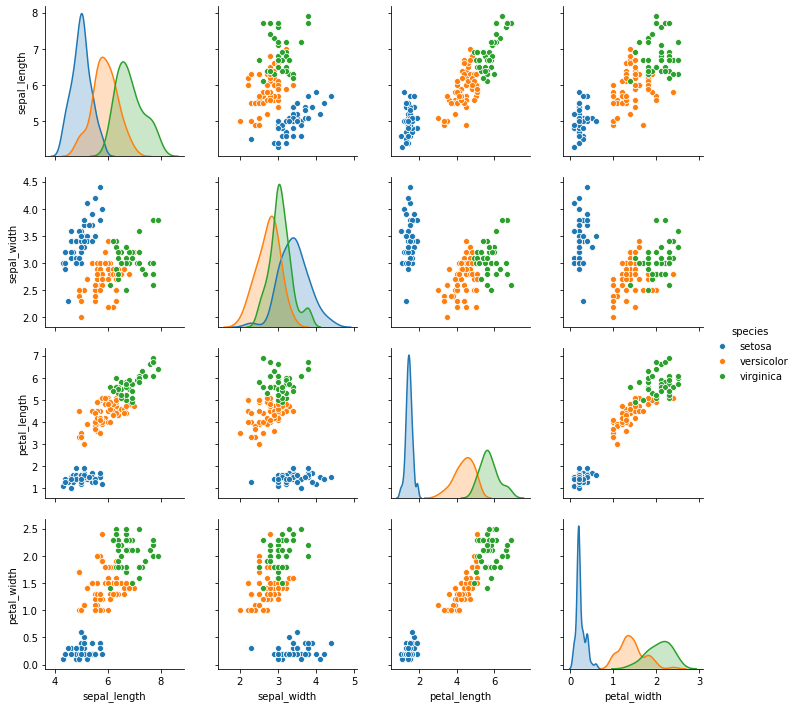

In [31]:
# This mapping from integer to string is cheating a bit
def map_labels(x):
    return {1: 'setosa', 0: 'versicolor', 2: 'virginica'}[x]
species = list(map(map_labels, species))

sns.pairplot(X.assign(species=species), hue='species')

Let's see how correct these would be in theory (we don't actually know the labels remember)

Theoretical clustering accuracy: 0.893


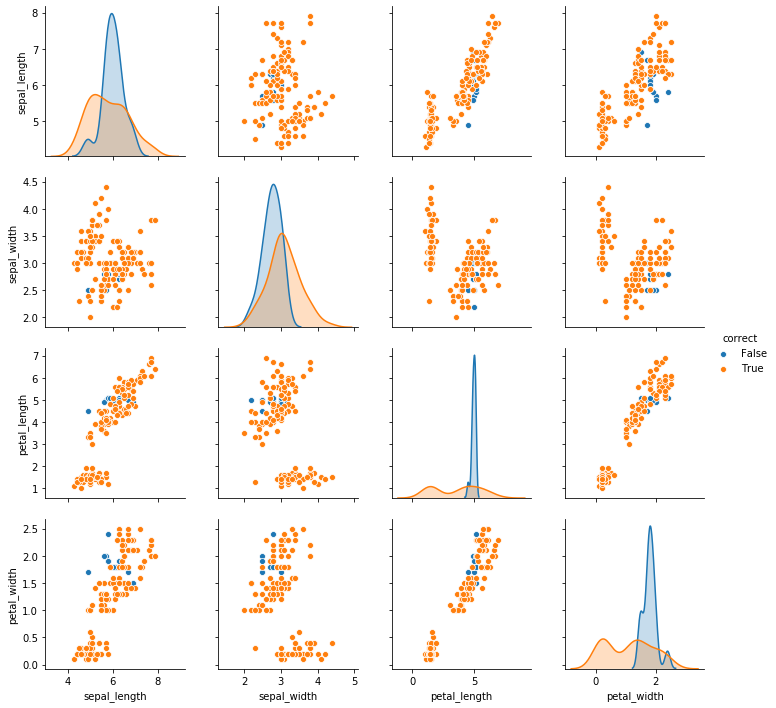

In [32]:
sns.pairplot(df_raw.assign(correct=lambda x: x.species == species), hue='correct', vars=X.columns)

print(f"Theoretical clustering accuracy: {(df_raw.species == species).mean():.3f}")

It's important to note that we got "lucky" here - a bad initialisation of the cluster centres can easily land us into local minima.

### Another example

Here we use a manifold learning algorithm, Isomap, to perform **dimensionality reduction** on hand-drawn digits.

Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points.

We will then use $k$-means to find clusters within this low dimensional representation.

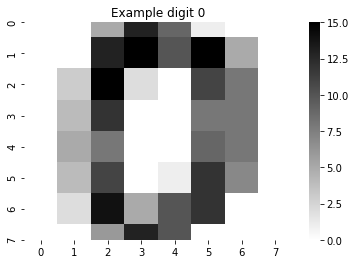

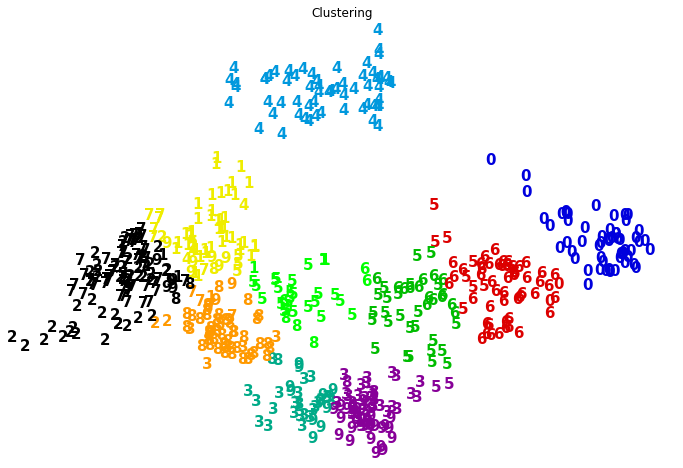

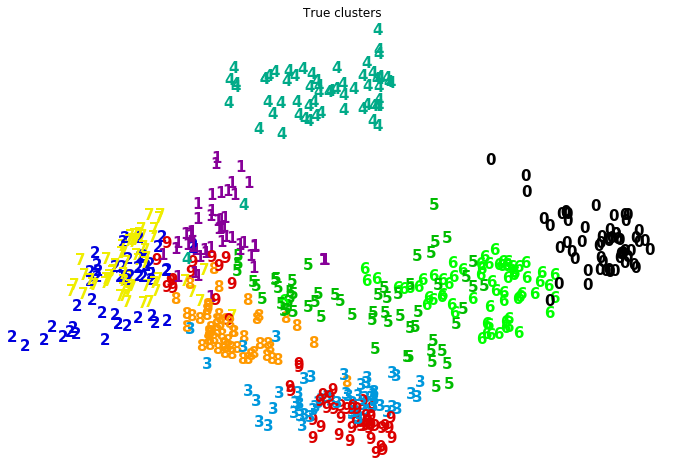

In [33]:
# Simplification of:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap

np.random.seed(0)

# Load dataset
digits = load_digits(n_class=10)
X = digits.data  # 1796 images x 64 pixels (8 by 8 images)
y = digits.target  # 0 - 9
n_samples, n_features = X.shape

# Example image
sns.heatmap(digits.data[0, :].reshape(8, 8), cmap='binary').set_title(f'Example digit {y[0]}')

    
# 2D embedding of the digits dataset
X_red = Isomap(n_components=2).fit_transform(X)

# Cluster based on 2D embedding
clustering = KMeans(n_clusters=10)
clustering.fit(X_red)

# Plot embedding
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    for i in range(0, X_red.shape[0], 3):
        ax.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 15})
    ax.set_title(title)
    return fig
        
plot_clustering(X_red, clustering.labels_, f"Clustering");
plot_clustering(X_red, y, "True clusters");

## Task: Classifying digits

Build a supervised machine learning pipeline to classify the digits dataset above.

Too easy? Pick another dataset from [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) and have a play around, or help anyone next to you who might be struggling.

# Closing remarks

Be careful where "best performance" leads you - the world is non-stationary and any system you build may effect it and feedback into your data.

We've only scratched the surface today - we've covered just enough for you to be able to start solving machine learning problems but there's many pitfalls we might still fall into which can be avoided by learning more theory and practice.

A non-extensive list of things we haven't covered today:
* Exploratory data analysis
* Converting text data to numeric features
* Dealing with highly imbalanced classes
* Better evaluating classifiers
    * Confusion matrices
    * ROC & precision-recall curves
    * F1 scores, and when to use what metric
        <!-- e.g. accuracy bad for imbalanced datasets. -->
* Regression metrics
* Learning and validation curves
* How to evaluate unsupervised ML models
* Regularisation
* Feature selection
* Ensemble methods
* Model explanations
* Multi-output models
* Multi-label classification
* Advanced cross-validation strategies

# Resources



* https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

    Here's a nice flow chart suggesting what techniques might apply to your problem:
    ![](figures/skl_cheat_sheet.png)


* https://scikit-learn.org/stable/modules/classes.html
    
    `scikit-learn` API reference

* https://scikit-learn.org/stable/user_guide.html#user-guide

    `scikit-learn` user guide

* [Python Data Science handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) [**(PDF)**](https://tanthiamhuat.files.wordpress.com/2018/04/pythondatasciencehandbook.pdf)

* https://www.datacamp.com/community/blog/scikit-learn-cheat-sheet

A few useful libraries:
    
* [yellowbrick](https://www.scikit-yb.org/en/latest/) - Plotting tools for machine learning
* [xai](https://github.com/EthicalML/xai) - Explainability toolbox
* Model explanation/interpretation
    * [alibi](https://github.com/SeldonIO/alibi)
    * [SHAP](https://github.com/slundberg/shap)
    * [interpret](https://github.com/microsoft/interpret)